# Glacier Velocity to Thickness

In [1]:
import geopandas as gpd
import os
import rasterio as rio
from rasterio import plot, mask
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import pandas as pd
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from shapely.geometry import mapping

/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/plot.py:263: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(arr.shape) is 2:


In [2]:
velocity_dir = '/home/jovyan/glacier-thickness-from-sar/import_data/velocities/'
validation_dir = '/home/jovyan/glacier-thickness-from-sar/validation_data/RGI60-02.14297_thickness.tif'
file = 'feb-mar_vel.tif'
vels = 'feb-mar_vel_proj.tif'
vels_clip = 'clipped_vel_feb_march_25.tif'

dst_crs = 'EPSG:32610'
geo_crop_dir = '/home/jovyan/glacier-thickness-from-sar/import_data/sar_images_geocoded_cropped'
shapefile_dir = '/home/jovyan/glacier-thickness-from-sar/import_data/glacier_shapefile/emmons_glacier.geojson'
emmons = gpd.read_file(shapefile_dir)

In [3]:
!gdalwarp -r cubic -t_srs $dst_crs $velocity_dir/$file $velocity_dir/$vels

Processing /home/jovyan/glacier-thickness-from-sar/import_data/velocities//feb-mar_vel.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [4]:
gvf_reader = rio.open(f'{velocity_dir}/{vels}')
gvf = gvf_reader.read(1)

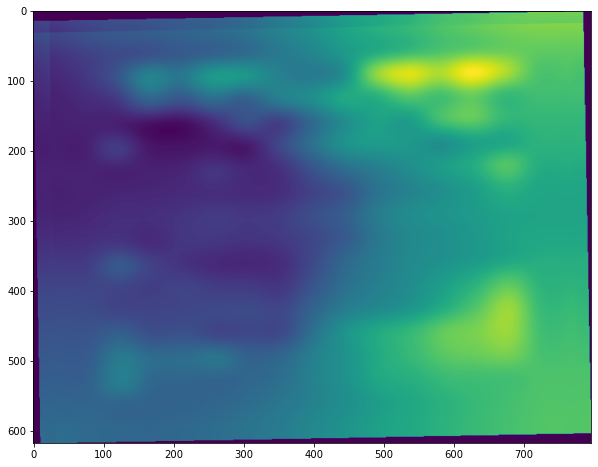

In [5]:
f,ax=plt.subplots(figsize=(10,10))
emmons.plot(ax=ax)
ax.imshow(gvf)

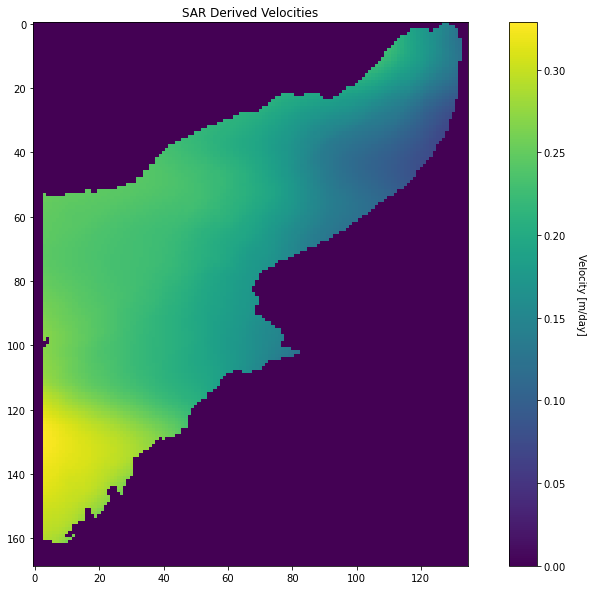

In [6]:
gvf_clip_reader = rio.open(f'{velocity_dir}/{vels_clip}')
gvf_clip = gvf_clip_reader.read(1)
f,ax=plt.subplots(figsize=(15,10))
vs = ax.imshow(gvf_clip)
cbar = f.colorbar(vs)
ax.set_title('SAR Derived Velocities')
cbar.set_label('Velocity [m/day]', rotation=270)
cbar.ax.get_yaxis().labelpad = 20

# Thickness Calculation

In [7]:
alpha = 30.6 # degrees
rho = 900 # kg m^-3
g = 9.8 # m/s^2
n = 3
A = 3.24E-24 # pa^-3s^-1
gvf_ms = gvf_clip/86400

In [8]:
thickness = (2*gvf_ms/(A*(rho*g*np.sin(np.deg2rad(alpha)))**3))**(1/4)

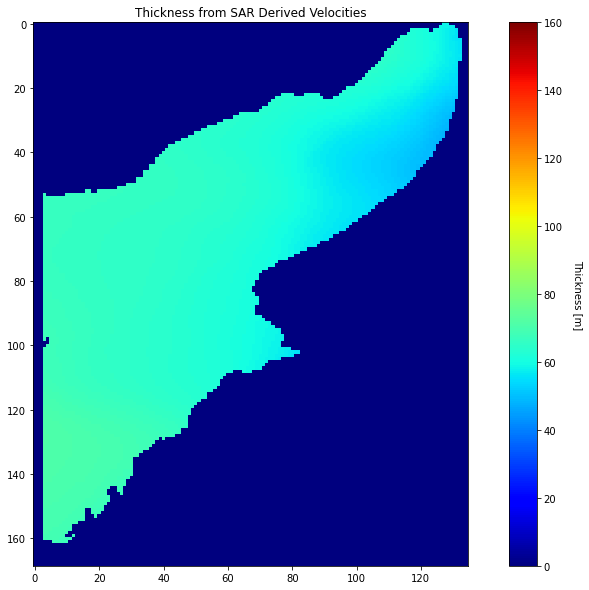

In [9]:
f,ax=plt.subplots(figsize=(15,10))
h = ax.imshow(thickness,cmap='jet',vmin=0,vmax=160)
cbar = f.colorbar(h)
ax.set_title('Thickness from SAR Derived Velocities')
cbar.set_label('Thickness [m]', rotation=270)
cbar.ax.get_yaxis().labelpad = 20

# validation

In [10]:
thickness_validation = plt.imread(validation_dir)

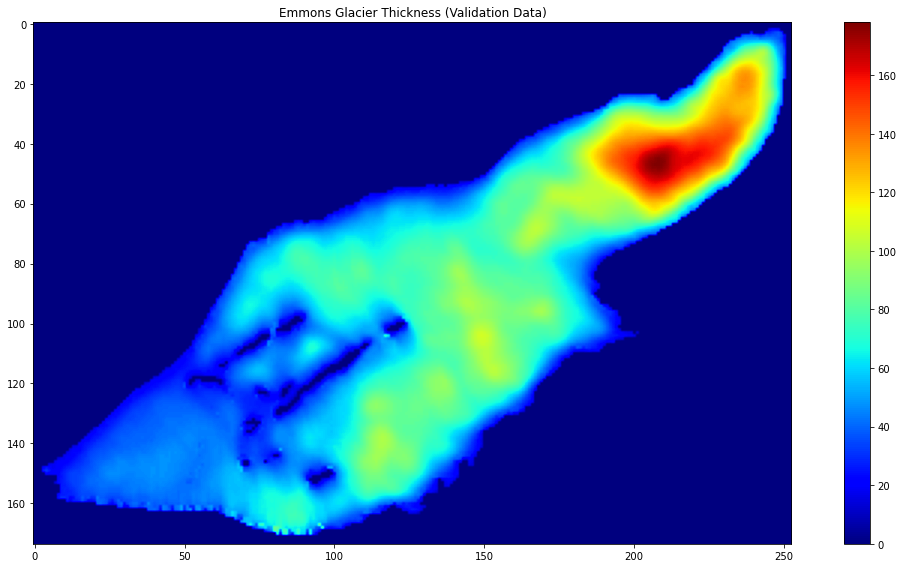

In [11]:
f, ax = plt.subplots(figsize=(15,8))
elevs = ax.imshow(thickness_validation[:,:,0],cmap='jet')
f.colorbar(elevs)
ax.set_title('Emmons Glacier Thickness (Validation Data)')
plt.tight_layout()

# improved with f=0.8

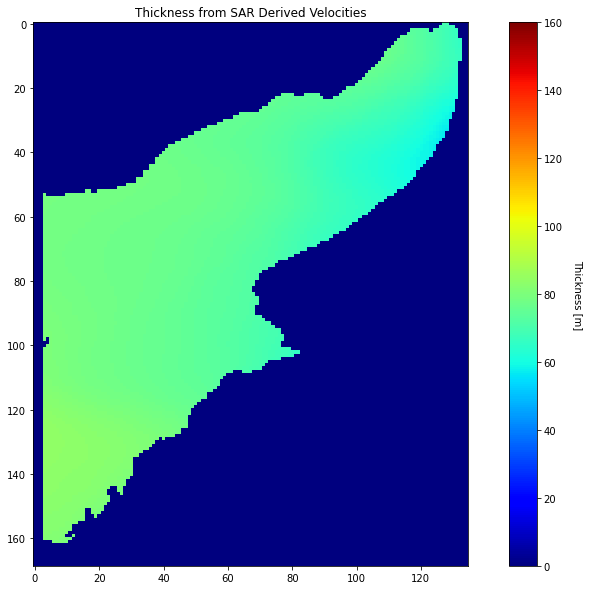

In [12]:
thickness_improve = (2*gvf_ms/(A*(0.8*rho*g*np.sin(np.deg2rad(alpha)))**3))**(1/4)
f,ax=plt.subplots(figsize=(15,10))
h = ax.imshow(thickness_improve,cmap='jet',vmin=0,vmax=160)
cbar = f.colorbar(h)
ax.set_title('Thickness from SAR Derived Velocities')
cbar.set_label('Thickness [m]', rotation=270)
cbar.ax.get_yaxis().labelpad = 20

# comparison

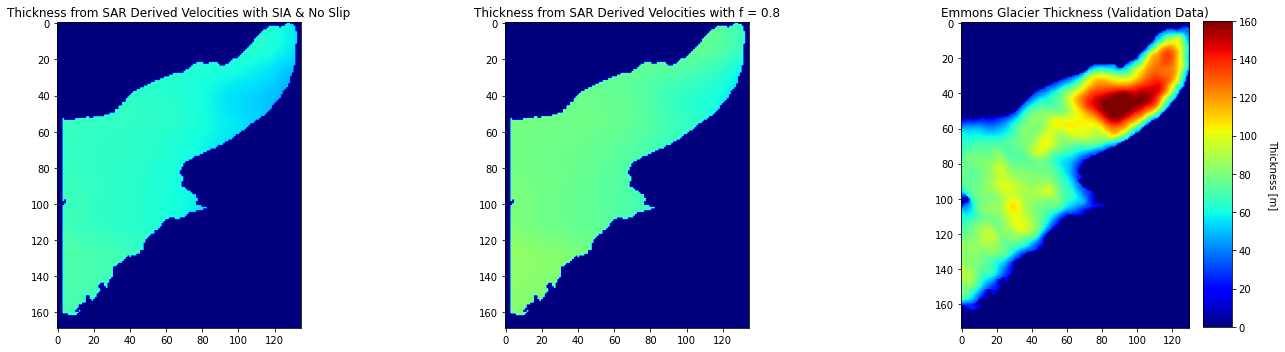

In [95]:
f,ax=plt.subplots(ncols=3,figsize=(20,5))
ax[0].imshow(thickness,cmap='jet',vmin=0,vmax=160)
ax[0].set_title('Thickness from SAR Derived Velocities with SIA & No Slip')
ax[1].imshow(thickness_improve,cmap='jet',vmin=0,vmax=160)
ax[1].set_title('Thickness from SAR Derived Velocities with f = 0.8')
colors = ax[2].imshow(thickness_validation[:,120:250,0],cmap='jet',vmin=0,vmax=160)
ax[2].set_title('Emmons Glacier Thickness (Validation Data)')
plt.tight_layout()
cb_ax = f.add_axes([0.9, 0.08, 0.02, 0.85])
cbar = f.colorbar(colors,cax=cb_ax)
cbar.set_label('Thickness [m]', rotation=270)
cbar.ax.get_yaxis().labelpad = 20

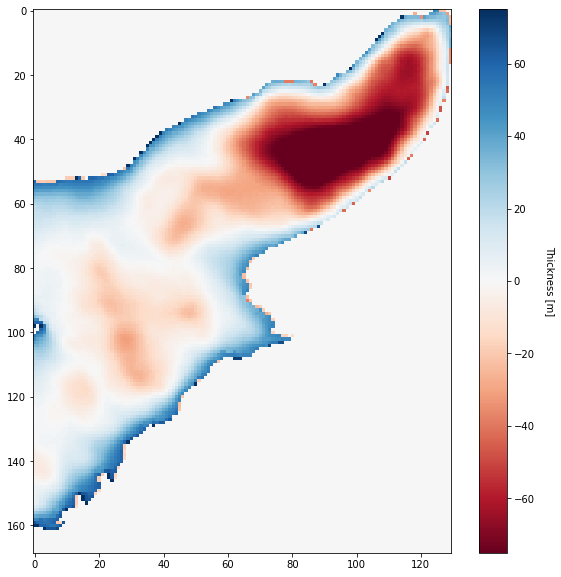

In [94]:
f,ax=plt.subplots(figsize=(10,10))
colors = ax.imshow(thickness_improve[:,3:133]-thickness_validation[2:171,121:251,0],cmap='RdBu',vmin=-75,vmax=75)
cbar = f.colorbar(colors)
cbar.set_label('Thickness [m]', rotation=270)
cbar.ax.get_yaxis().labelpad = 20

In [93]:
diff_mean = np.mean(thickness_improve[:,3:133]-thickness_validation[2:171,121:251,0])
print(f'The average difference between our calculated thickness and our validation data is {diff_mean} meters.')

The average difference between our calculated thickness and our validation data is -3.5306193771806007 meters.
